In [1]:
import scipy.constants as consts
from lib.AtomNumbers import QD, Rb87, State, TermEnergy
import lib.DipoleDipoleInteractions as ddi
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sympy import *
import datetime
%matplotlib inline

No database file found at ../data/RMEdbs/Rb87.sqlite3


In [2]:
sI1 = State(97, 2, 2.5, 2.5) # center molecular state
sI2 = sI1
ED_order = 2 # electric dipole transtitions
E_cut = 1e9/consts.c # 1/m
F_cut = 1 # c3/R^3 (GHz/um**3), only include state with non-negligable coulpings
R0 = 3 # perform F_cut at R0 (um)

#### Find all states with same angular momentum as the center state within E_cut of the center

In [3]:
E0 = TermEnergy(Rb87, sI1)[0]+TermEnergy(Rb87, sI2)[0] # center energy
E_range = (consts.c*(E0-E_cut),consts.c*(E0+E_cut))
n1_min, n1_max = (sI1.n-10, sI1.n+10)
n2_min, n2_max = (sI2.n-10, sI2.n+10)
l_min = max(0,min(sI1.l-ED_order,sI2.l-ED_order))
l_max = max(sI1.l+ED_order,sI2.l+ED_order)
mj_total = sI1.mj + sI2.mj

states1 = [ State(n,sI1.l,sI1.j,sI1.mj) for n in range(n1_min,n1_max+1)]
states2 = [ State(n,sI2.l,sI2.j,sI2.mj) for n in range(n2_min,n2_max+1)]

molecular_states = [[]]
for s1 in states1:
  for s2 in states2:
    E = TermEnergy(Rb87, s1)[0]+TermEnergy(Rb87, s2)[0]
    if abs(E-E0)<E_cut:
      molecular_states[0].append(((s1,s2),consts.c*(E-E0)))
      print "{} + {}: {}".format(s1,s2,consts.c*(E-E0))
    
print(len(molecular_states[0]))

90D_5/2, mj=5/2 + 106D_5/2, mj=5/2: 161051688.127
92D_5/2, mj=5/2 + 103D_5/2, mj=5/2: 435817346.119
95D_5/2, mj=5/2 + 99D_5/2, mj=5/2: -943828323.306
96D_5/2, mj=5/2 + 98D_5/2, mj=5/2: -235828133.763
97D_5/2, mj=5/2 + 97D_5/2, mj=5/2: 0.0
98D_5/2, mj=5/2 + 96D_5/2, mj=5/2: -235828133.763
99D_5/2, mj=5/2 + 95D_5/2, mj=5/2: -943828323.306
103D_5/2, mj=5/2 + 92D_5/2, mj=5/2: 435817346.119
106D_5/2, mj=5/2 + 90D_5/2, mj=5/2: 161051688.127
9


#### Find all states that couple to the previous order of states

In [4]:
n1_range = (n1_min,n1_max)
n2_range = (n2_min,n2_max)
for o in range(ED_order):
  ms_class = molecular_states[o]
  ang_mom_list = ddi.next_ED_order(ms_class)
  #print ang_mom_list
  temp = set()
  for ms in ms_class:
    #print ms[0]
    t = ddi.filter_molecular_states(Rb87, ms[0][0], ms[0][1], ang_mom_list, E_range, F_cut, R0, n1_range, n2_range)
    temp.update(t)
  molecular_states.append([])
  for x in temp:
    n,l,j,m = x[0]
    ts1 = State(n,l,j,m)
    n,l,j,m = x[1]
    ts2 = State(n,l,j,m)
    te = consts.c*(TermEnergy(Rb87, s1)[0]+TermEnergy(Rb87, s2)[0])
    molecular_states[o+1].append(((ts1,ts2),te))

In [5]:
print(len(molecular_states[0]))
print(len(molecular_states[1]))
print(len(molecular_states[2]))

9
28
105


In [6]:
basis = set()
for ms_class in molecular_states:
  for ms in ms_class:
    basis.add( (ms[0][0].state_tuple(), ms[0][1].state_tuple()) )
basis = list(basis)
print(len(basis))

basis_states = []
for ms in basis:
  basis_states.append((State(ms[0][0],ms[0][1],ms[0][2],ms[0][3]), State(ms[1][0],ms[1][1],ms[1][2],ms[1][3])))

133


In [7]:
fd = []
for ms in basis_states:
  fd.append(consts.c*(TermEnergy(Rb87,ms[0])[0]+TermEnergy(Rb87,ms[1])[0]-E0)*1e-9) #GHz
forster_defects = np.array(fd)

### Build the Hamiltonian

In [8]:
dimension = len(basis) # add on the initial state
Hcoupling = np.zeros((dimension,dimension))
for i in xrange(dimension):
  for j in xrange(dimension):
    ms1 = basis_states[i]
    ms2 = basis_states[j]
    temp = Rb87.c3(ms1[0],ms1[1],ms2[0],ms2[1])
    if temp != 0:
      Hcoupling[i][j] = temp[0]
      Hcoupling[j][i] = temp[0]

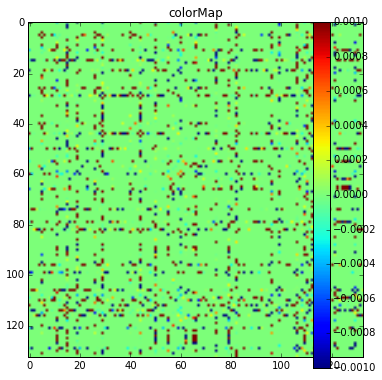

In [9]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
lim=0.001
plt.imshow(Hcoupling, vmin=-lim, vmax=lim)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cb = plt.colorbar(orientation='vertical')
plt.show()

#### verify at large R (100 um)

In [10]:
cindex = np.abs(forster_defects).argsort()[0]

In [11]:
ddi.getRelevantCouplings(Hcoupling, forster_defects, 100, 0.001)

[[100,
  array(-3.8002536306793306e-08),
  0.99999982334141913,
  array([ 27,  26,  55,  11, 110])]]

In [12]:
basis[cindex]

((97, 2, 2.5, 2.5), (97, 2, 2.5, 2.5))

#### Calculate blockade curves

In [13]:
data = []

In [14]:
r_start = 3
r_stop = 15
samples = 500
r_last = 0
for r in np.linspace(r_start,r_stop,samples):
    current_time = datetime.datetime.now().time()
    if int(r) > int(r_last):
      print(r)
      print(current_time.isoformat())
      r_last = r
    data = data + ddi.getRelevantCouplings(Hcoupling, forster_defects, r, 0.01, 1.0)

3.0
21:27:09.947462
4.01002004008
21:27:10.611234
5.02004008016
21:27:11.224858
6.00601202405
21:27:11.819708
7.01603206413
21:27:12.415496
8.00200400802
21:27:13.077385
9.0120240481
21:27:13.681386
10.0220440882
21:27:14.395713
11.0080160321
21:27:15.033864
12.0180360721
21:27:15.713419
13.004008016
21:27:16.280056
14.0140280561
21:27:16.860541
15.0
21:27:17.440723


In [15]:
mark_r = [0.20202, 0.40404, 0.606061, 0.808081, 1.0101, 1.21212, 1.41414, \
1.61616, 1.81818, 2.0202, 2.22222, 2.42424, 2.62626, 2.82828, 3.0303, \
3.23232, 3.43434, 3.63636, 3.83838, 4.0404, 4.24242, 4.44444, \
4.64646, 4.84848, 5.05051, 5.25253, 5.45455, 5.65657, 5.85859, \
6.06061, 6.26263, 6.46465, 6.66667, 6.86869, 7.07071, 7.27273, \
7.47475, 7.67677, 7.87879, 8.08081, 8.28283, 8.48485, 8.68687, \
8.88889, 9.09091, 9.29293, 9.49495, 9.69697, 9.89899, 10.101, 10.303, \
10.5051, 10.7071, 10.9091, 11.1111, 11.3131, 11.5152, 11.7172, \
11.9192, 12.1212, 12.3232, 12.5253, 12.7273, 12.9293, 13.1313, \
13.3333, 13.5354, 13.7374, 13.9394, 14.1414, 14.3434, 14.5455, \
14.7475, 14.9495, 15.1515, 15.3535, 15.5556, 15.7576, 15.9596, \
16.1616, 16.3636, 16.5657, 16.7677, 16.9697, 17.1717, 17.3737, \
17.5758, 17.7778, 17.9798, 18.1818, 18.3838, 18.5859, 18.7879, \
18.9899, 19.1919, 19.3939, 19.596, 19.798, 20.]
mark_B = [-10966.3, -1370.79, -406.16, -171.349, -87.7303, -50.7695, -31.971, \
-21.4175, -15.0414, -10.9642, -8.23635, -6.34261, -4.98687, -3.99069, \
-3.24218, -2.66872, -2.22181, -1.86818, -1.58454, -1.35422, -1.16507, \
-1.00814, -0.876692, -0.76563, -0.671032, -0.589863, -0.51975, \
-0.458827, -0.405612, -0.358925, -0.317818, -0.281522, -0.24941, \
-0.220963, -0.195746, -0.17339, -0.153577, -0.136026, -0.120493, \
-0.106757, -0.0946198, -0.0839036, -0.074448, -0.0661083, -0.0587547, \
-0.0522711, -0.0465538, -0.0415106, -0.0370599, -0.0331295, \
-0.0296559, -0.0265832, -0.0238624, -0.0214505, -0.01931, -0.017408, \
-0.0157157, -0.0142081, -0.0128632, -0.0116618, -0.0105871, \
-0.00962452, -0.00876107, -0.00798552, -0.00728798, -0.00665975, \
-0.00609318, -0.00558157, -0.00511896, -0.00470014, -0.00432048, \
-0.0039759, -0.00366277, -0.00337787, -0.00311837, -0.00288173, \
-0.00266568, -0.00246822, -0.00228756, -0.00212208, -0.00197036, \
-0.0018311, -0.00170316, -0.0015855, -0.0014772, -0.00137741, \
-0.00128538, -0.00120043, -0.00112194, -0.00104937, -0.000982209, \
-0.00092, -0.000862334, -0.000808835, -0.000759164, -0.000713011, \
-0.000670096, -0.00063016, -0.000592972]

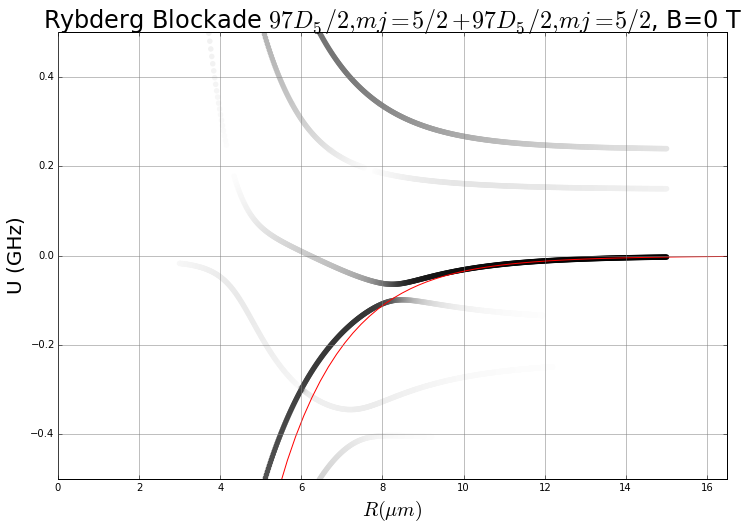

In [16]:
plt.figure(figsize=(12,8))

x =[]
x.append([ d[0] for d in data ])
x.append([ d[1] for d in data ])
x.append(np.real([ 1-sqrt(d[2]) for d in data ]))

idx = x[2].argsort()[::-1]
x[0] = [ x[0][i] for i in idx ]
x[1] = [ x[1][i] for i in idx ]
x[2] = [ x[2][i] for i in idx ]

plt.scatter(x[0], x[1], c=x[2], marker='o', s=30, vmax=1, vmin=0, linewidth=0, alpha=1)
plt.plot(mark_r,mark_B, color='r')

plt.gray()
plt.ylim(-0.5,0.5)
plt.xlim(0,r_stop*1.1)

plt.grid(b=True, which='major', color='0.5', linestyle='-')
plt.grid(b=True, which='minor', color='0.75', linestyle='--')

plt.title('Rybderg Blockade ${}+{}$, B=0 T'.format(sI1,sI2), fontsize=24)
plt.xlabel('$R (\mu m)$', fontsize=20)
plt.ylabel('U (GHz)', fontsize=20)

#plt.savefig('MolecularResonances_B=370uT_97D52m52_97D52m52.pdf')
plt.show()